#Cross-Modality Metadata Matching in HTAN Datasets

```
Title: Cross-Modality Metadata Matching in HTAN Datasets
Author: Dar'ya Pozhidayeva (dpozhida@systemsbiology.org)
Created: May 28th, 2025
```

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Cross_Modality_Metadata_Matching_in_HTAN_Datasets.ipynb)

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer Moonshot initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ( [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)).

HTAN supports a variety of data reuse use cases. One common scenario involves matching files across different assay types using shared linkage keys, such as biospecimen IDs, participant IDs, or common file identifiers.



###⚠️PAUSE:
This notebook assumes prior familiarity with the HTAN ID Provenance BigQuery table and its structure. If needed, please review the background information here:https://github.com/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/HTAN_ID_Provenance_In_BQ.ipynb

### 1.1 Goal

In this notebook, we demonstrate how HTAN files can be matched across different assay types. Specifically, we present two examples: the first matches imaging data with spatial assays, and the second matches imaging data with sequencing assays.

### 1.2 Inputs, Outputs, & Data
The primary input to this notebook are Google BigQuery tables that contain metadata for files.

Metadata BigQuery tables correspond to a specific assay type (or component) and aggregate metadata across all files generated by that assay. These tables standardize and centralize key information—such as sample identifiers, file paths, data modalities, and processing details—enabling scalable access to multimodal metadata. By leveraging these structured tables, we match metadata matching between different components.

The outputs of this notebook are lists of files and their corresponding DRS_URI identifiers that represent matched biospecimen across different assay types in the HTAN dataset. Specifically, the notebook produces matched sets of files—such as H&E images and sequencing data—that originate from the same biospecimen, enabling cross-modal analysis.

DRS_URI identifiers are provided for data retrieval from the Cancer Research Data Commons (CRDC). They are standardized identifiers that follow the GA4GH Data Repository Service (DRS) specification, offering a consistent way to reference and access data files stored across cloud-based research commons like the CRDC.

DRS_URI identifiers are used to securely access controlled imaging data hosted in the CRDC Genomic Cloud (GC). Because imaging data is considered sensitive, access requires proper authorization (e.g., through dbGaP) and must occur in a secure cloud environment. The DRS_URI (e.g., drs://dg.4DFC:object-id) provides a standardized way to reference data across cloud platforms, allowing tools like Gen3 or Terra to locate and download data without revealing its physical storage location. This enables authorized users to integrate controlled imaging data into cloud-based workflows while ensuring compliance with data protection policies.


###1.3 Metadata Context
As described previously, in HTAN BigQuery tables, metadata is distributed across multiple tables, each corresponding to different assay types or data processing levels, and each containing only a subset of information (Figure 1).

To obtain a complete view of metadata for a single biospecimen, it's necessary to merge data from these different tables using common identifiers.

These common keys can include biospecimen IDs (e.g., `HTAN_Biospecimen_ID`), parent biospecimen IDs (e.g., `HTAN_Parent_Biospecimen_ID`), or participant IDs (e.g., `HTAN_Participant_ID`). By joining tables on these shared keys, researchers can reconstruct the full context of a sample, including its provenance, assay results, processing history, and associated data files.


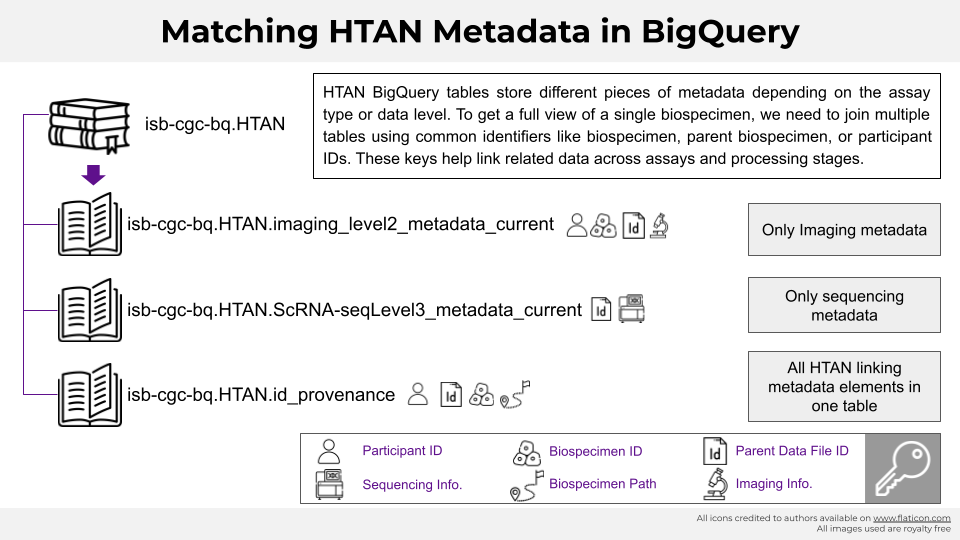

**Figure 1.** Matching HTAN Metadata in Bigquery.
This diagram explains how metadata from different assay types is organized and linked using Google BigQuery. Each table (e.g.,imaging_level2_metadata_current, ScRNA-seqLevel3_metadata_current) contains metadata specific to a particular modality and level. The id_provenance table serves as a central hub, containing linking identifiers.

This linking is crucial for multimodal integration and cross-assay analysis in HTAN.

###1.4 Notes
The queries and results in this notebook correspond to the most current ISB-CGC HTAN Release.

To choose a different release, edit the BigQuery table names in this notebook by replacing the string `current` with a selected numbered release, (`e.g., r2`) from our versioned archive.

# 2. Relevant Libraries for Analysis

To get started, we'll need to download and call just the pandas python library this time.

In [15]:
import pandas as pd

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

## 3.1 Authenticating with Google Credentials

#### Option 1. Running in Google Colab

Before getting started, keep in mind that there are some differences in running this notebook depending on if you are using Google Colab or running locally. We've included notes such as the following to skip or run specific lines of code depending on your setup.

If you are using Google Colab, run the code block below to authenticate:

In [16]:
from google.colab import auth
auth.authenticate_user()

#### Option 2. Running on local machine

Alternatively, if you're running the notebook locally, take the following steps to authenticate.

1.   Run `gcloud auth application-default login` on your local machine
2.   Run the command below replacing `<path to key>` with the path to your credentials file

In [17]:
#%env GOOGLE_APPLICATION_CREDENTIALS=<path to key>

## 3.2 Initializing the Google BigQuery client

In [18]:
# Import the Google BigQuery client
from google.cloud import bigquery

# Set the google project that will be billed for this notebook's computations
google_project = 'my-project'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

#4. Pull Data from Google BigQuery

##4.1 Matching Different Modalities Within the Same Metadata Table

In this example, let's say we'd like to match metadata on two imaging types using the biospecimen as a common linkage key. The SQL query we would build would start with the following imaging metadata table:

In [19]:
client.query("""
SELECT * FROM `isb-cgc-bq.HTAN.imaging_level2_metadata_current`
""").result().to_dataframe()

,Pixels_BigEndian,Frame_Averaging,WorkingDistanceUnit,Software_and_Version,HTAN_Data_File_ID,SizeY,Objective,MERFISH_Positions_File,MERFISH_Codebook_File,entityId,...,Image_ID,Filename,Passed_QC,HTAN_Center,Manifest_Id,Manifest_Version,File_Size,md5,Data_Release,GC_Release
0,False,None,None,MERlin,HTA1_313_932304000000,2048,None,syn25705623,syn25705617,syn25510468,...,Image:0,merfish_level_2/HTAPP-313_slice4/processed_ima...,Yes,HTAN HTAPP,syn41754091,10,1468028692,5f466275ffdae431723fce0a5fe0bfa7,Release 4.0,v24.8.1.img
1,False,None,None,MERlin,HTA1_313_932304001001,2048,None,syn25705623,syn25705617,syn25513257,...,Image:0,merfish_level_2/HTAPP-313_slice4/processed_ima...,Yes,HTAN HTAPP,syn41754091,10,1468028692,5d7281c64a3564bb164916892d877fea,Release 4.0,v24.8.1.img
2,False,None,None,MERlin,HTA1_313_932304010010,2048,None,syn25705623,syn25705617,syn25513284,...,Image:0,merfish_level_2/HTAPP-313_slice4/processed_ima...,Yes,HTAN HTAPP,syn41754091,10,1468028692,0abdb8303437d1fdbcc8230b0c1fbeb2,Release 4.0,v24.8.1.img
3,False,None,None,MERlin,HTA1_313_932304100100,2048,None,syn25705623,syn25705617,syn25510749,...,Image:0,merfish_level_2/HTAPP-313_slice4/processed_ima...,Yes,HTAN HTAPP,syn41754091,10,1468028692,1beb9924ec5a81307578120b12e3d220,Release 4.0,v24.8.1.img
4,False,None,None,MERlin,HTA1_313_932304101101,2048,None,syn25705623,syn25705617,syn25514031,...,Image:0,merfish_level_2/HTAPP-313_slice4/processed_ima...,Yes,HTAN HTAPP,syn41754091,10,1468028692,43214d006b3938725b3ecccaf007d3af,Release 4.0,v24.8.1.img
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25505,False,None,µm,Ashlar v1.13.0+4.gf73a8fd (Glencoe/Faas pyrami...,HTA13_1_5086,39803,None,None,None,syn26486785,...,Image:0,sardana_phase_1_ffpe_level_2/WD-76845-082.ome.tif,Yes,HTAN TNP SARDANA,syn41746067,1,41162846644,5e755ec2aae13d74797d464d8038306b,Release 2.0,v22.6.2.img
25506,False,None,µm,Ashlar v1.13.0+4.gf73a8fd (Glencoe/Faas pyrami...,HTA13_1_5208,22547,None,None,None,syn26486787,...,Image:0,sardana_phase_1_ffpe_level_2/WD-76847-072.ome.tif,Yes,HTAN TNP SARDANA,syn41746067,1,109390160268,4a3dbd6a45d2a7d85fa5d01df12306fc,Release 2.0,v22.6.2.img
25507,False,None,µm,Ashlar v1.13.0+4.gf73a8fd (Glencoe/Faas pyrami...,HTA13_1_5212,43476,None,None,None,syn26486789,...,Image:0,sardana_phase_1_ffpe_level_2/WD-76847-076.ome.tif,Yes,HTAN TNP SARDANA,syn41746067,1,170334793189,6c1c7bea8b531bddacbabda436fe9108,Release 2.0,v22.6.2.img
25508,False,None,µm,Ashlar v1.13.0+4.gf73a8fd (Glencoe/Faas pyrami...,HTA13_1_5215,38076,None,None,None,syn26486791,...,Image:0,sardana_phase_1_ffpe_level_2/WD-76847-079.ome.tif,Yes,HTAN TNP SARDANA,syn41746067,1,37560905684,e83739bd4d3d275ee80d53c8100a1b94,Release 2.0,v22.6.2.img


To obtain metadata related to different imaging types, we will focus on the column labeled Imaging_Assay_Type.

Since we're interested in biospecimen samples that have both H&E and MxIF imaging available, we'll create a count table where each sample is grouped and only included if it has at least one assay of type H&E and one of type MxIF.

In [20]:
client.query("""
  SELECT
    img.HTAN_Center,
    img.HTAN_Parent_Biospecimen_ID,
    COUNT(DISTINCT img.Imaging_Assay_Type) AS assay_type_count,
    STRING_AGG(DISTINCT img.Imaging_Assay_Type, ', ') AS assay_types
  FROM `isb-cgc-bq.HTAN.imaging_level2_metadata_current` img
  WHERE img.Data_Release IS NOT NULL
    AND img.Imaging_Assay_Type IN ('H&E', 'MxIF')
  GROUP BY
    img.HTAN_Parent_Biospecimen_ID,
    img.HTAN_Center
  HAVING
    COUNT(DISTINCT img.Imaging_Assay_Type) > 1
    AND COUNTIF(img.Imaging_Assay_Type = 'H&E') > 0
""").result().to_dataframe()

,HTAN_Center,HTAN_Parent_Biospecimen_ID,assay_type_count,assay_types
0,HTAN Vanderbilt,HTA11_1391_2000001011,2,"MxIF, H&E"
1,HTAN Vanderbilt,HTA11_1938_2000001011,2,"MxIF, H&E"
2,HTAN Vanderbilt,HTA11_2112_2000001011,2,"MxIF, H&E"
3,HTAN Vanderbilt,HTA11_2235_2000001011,2,"MxIF, H&E"
4,HTAN Vanderbilt,HTA11_2487_2000001011,2,"MxIF, H&E"
5,HTAN Vanderbilt,HTA11_2951_2000001011,2,"MxIF, H&E"
6,HTAN Vanderbilt,HTA11_3077_2000001011,2,"MxIF, H&E"
7,HTAN Vanderbilt,HTA11_3252_2000001011,2,"MxIF, H&E"
8,HTAN Vanderbilt,HTA11_3331_2000001011,2,"MxIF, H&E"
9,HTAN Vanderbilt,HTA11_3361_2000001011,2,"MxIF, H&E"


Finally, we’ll join this count table back to the original imaging table to retrieve the associated file information and link it with our DRS_URI mapping table. This will allow us to access the data and perform any analyses as needed.

In [21]:
matched_imaging_table = client.query("""
--
WITH multi_assay_biospecimens AS (
  SELECT
    img.HTAN_Center,
    img.HTAN_Parent_Biospecimen_ID,
    COUNT(DISTINCT img.Imaging_Assay_Type) AS assay_type_count,
    STRING_AGG(DISTINCT img.Imaging_Assay_Type, ', ') AS assay_types
  FROM `isb-cgc-bq.HTAN.imaging_level2_metadata_current` img
  WHERE img.Data_Release IS NOT NULL
    AND img.Imaging_Assay_Type IN ('H&E', 'MxIF')
  GROUP BY
    img.HTAN_Parent_Biospecimen_ID,
    img.HTAN_Center
  HAVING
    COUNT(DISTINCT img.Imaging_Assay_Type) > 1
    AND COUNTIF(img.Imaging_Assay_Type = 'H&E') > 0
)

SELECT
  img.HTAN_Data_File_ID,
  img.GC_Release,
  img.Imaging_Assay_Type,
  m.assay_type_count,
  m.assay_types,
  drs.drs_uri
FROM `isb-cgc-bq.HTAN.imaging_level2_metadata_current` img
JOIN multi_assay_biospecimens m
  ON img.HTAN_Center = m.HTAN_Center
  AND img.HTAN_Parent_Biospecimen_ID = m.HTAN_Parent_Biospecimen_ID
LEFT JOIN `isb-cgc-bq.HTAN.gc_drs_map_current` drs
  ON drs.HTAN_Data_File_ID = img.HTAN_Data_File_ID
WHERE img.Data_Release IS NOT NULL

""").result().to_dataframe()

The resulting output for this matched table looks like this:

In [22]:
matched_imaging_table

,HTAN_Data_File_ID,GC_Release,Imaging_Assay_Type,assay_type_count,assay_types,drs_uri
0,HTA11_1391_20000010115220280010000000000,v24.8.1.img,MxIF,2,"MxIF, H&E",dg.4DFC/75E24251-7FBB-41DF-8786-32924B374E3C
1,HTA11_1391_20000010115220280020000000000,v24.8.1.img,MxIF,2,"MxIF, H&E",dg.4DFC/9685B1B0-4BDC-4565-B5D5-22D067222BDF
2,HTA11_1391_20000010115220280030000000000,v24.8.1.img,MxIF,2,"MxIF, H&E",dg.4DFC/714D1BCE-C04B-4313-90D8-DF5C09DEF3D8
3,HTA11_1938_20000010115220280010000000000,v24.8.1.img,MxIF,2,"MxIF, H&E",dg.4DFC/2E1596B2-493D-4EAA-B396-403486E96FDD
4,HTA11_1938_20000010115220280020000000000,v24.8.1.img,MxIF,2,"MxIF, H&E",dg.4DFC/B1327DFE-15A3-491B-A330-E78C9DEA399D
...,...,...,...,...,...,...
118,HTA11_6147_20000010116110030010000009999,v24.8.1.img,H&E,2,"MxIF, H&E",dg.4DFC/6DD7D467-DEFC-44E1-89F7-3F61A2EFD97D
119,HTA11_6310_20000010116110030010000009999,v24.8.1.img,H&E,2,"MxIF, H&E",dg.4DFC/3F7AC313-A9C4-4752-8D7F-3F7FC97F8105
120,HTA11_696_20000010116110030010000009999,v24.8.1.img,H&E,2,"MxIF, H&E",dg.4DFC/F51998AE-80AD-4635-84E2-4C6BDABD057C
121,HTA11_83_20000010116110030010000009999,v24.8.1.img,H&E,2,"MxIF, H&E",dg.4DFC/279EE516-360E-4B7D-98AD-8ED7C0F88157


####**Key Overview of Steps:**

**1. Filter Imaging Data:**

Select records from the ImagingLevel2 table that have a non-null Data_Release and an Imaging_Assay_Type of either 'H&E' or 'MxIF'.

**2. Identify Multi-Assay Samples:**

Group by HTAN_Center and HTAN_Parent_Biospecimen_ID.
Keep only those biospecimens that have both 'H&E' and 'MxIF' assay types.
Count and aggregate the distinct assay types for each sample.

**3. Join with Full Imaging Table:**

Rejoin the filtered biospecimen list back to the full ImagingLevel2 imaging table to retrieve detailed imaging file information.

**4. Link DRS URIs:**

Left join with the gc_drs_map_current table to map each file to its corresponding drs_uri.

**5. Select Final Output Columns:**

Return fields such as HTAN_Data_File_ID, GC_Release, Imaging_Assay_Type, assay count, assay type list, and drs_uri.

##Matching Different Modalities Across Two Separate Metadata Tables

In our next example, we’re interested in combining two different modalities from separate metadata tables. We'll begin by examining the sequencing data of interest—in this case, scRNA-seq Level 3.

In [23]:
client.query("""
SELECT * FROM `isb-cgc-bq.HTAN.scRNAseq_level3_metadata_current`
""").result().to_dataframe()

,HTAN_Parent_Data_File_ID,scRNAseq_Workflow_Type,Id,scRNAseq_Workflow_Parameters_Description,Cell_Median_Number_Reads,entityId,Cell_Median_Number_Genes,Linked_Matrices,Matrix_Type,Cell_Total,...,Workflow_Link,Filename,File_Format,HTAN_Center,Manifest_Id,Manifest_Version,File_Size,md5,Data_Release,GC_Release
0,HTA1_272_4831101101,CellRanger,13bd7031-ef84-41fa-a206-29fd3b484099,Cumulus cellranger_workflow with default setti...,Not Applicable,syn24181451,Not Applicable,None,Raw Counts,Not Applicable,...,https://portal.firecloud.org/?return=terra#met...,single_cell_RNAseq_level_3_colon/HTAPP-272-SMP...,tsv,HTAN HTAPP,syn41762804,4,14008320,f010059d7160aac2dad1805e1496bf71,Release 1.0,None
1,HTA1_272_4831101101,CellRanger,2f319ce1-6b8a-4da1-a477-935d20454599,Cumulus cellranger_workflow with default setti...,Not Applicable,syn24181449,Not Applicable,None,Raw Counts,Not Applicable,...,https://portal.firecloud.org/?return=terra#met...,single_cell_RNAseq_level_3_colon/HTAPP-272-SMP...,tsv,HTAN HTAPP,syn41762804,4,816952,17e0ac5741a5830c8bc69576e3d5f844,Release 1.0,None
2,HTA1_272_4831101101,CellRanger,3f003bcd-bb5e-44aa-b288-00f9d1ec1e22,Cumulus cellranger_workflow with default setti...,"18,597",syn24181474,"3,298",None,Raw Counts,871,...,https://portal.firecloud.org/?return=terra#met...,single_cell_RNAseq_level_3_colon/HTAPP-272-SMP...,mtx,HTAN HTAPP,syn41762804,4,102378303,3d3d6bb74f4c42a471c72ec259d6e37a,Release 1.0,None
3,HTA1_273_4861101101,CellRanger,167ef220-80f3-401e-8a23-e2a2043e2445,Cumulus cellranger_workflow with default setti...,Not Applicable,syn24181478,Not Applicable,None,Raw Counts,Not Applicable,...,https://portal.firecloud.org/?return=terra#met...,single_cell_RNAseq_level_3_colon/HTAPP-273-SMP...,tsv,HTAN HTAPP,syn41762804,4,14008320,f010059d7160aac2dad1805e1496bf71,Release 1.0,None
4,HTA1_273_4861101101,CellRanger,8621f64b-87a0-4704-866c-8ab72caee0a6,Cumulus cellranger_workflow with default setti...,Not Applicable,syn24181485,Not Applicable,None,Raw Counts,Not Applicable,...,https://portal.firecloud.org/?return=terra#met...,single_cell_RNAseq_level_3_colon/HTAPP-273-SMP...,tsv,HTAN HTAPP,syn41762804,4,816952,17e0ac5741a5830c8bc69576e3d5f844,Release 1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,HTA10_05_42063297986385692047074634353427,CellRanger,996ade9d-950a-4750-9c00-477f8e346d3f,Run cellranger count with transcriptome=GRCh38...,1489.0,syn26531147,1082.0,None,Raw Counts,6923,...,https://github.com/winstonbecker/scCRC_continuum,scrnaseq_level_3/F072B_features.tsv.gz,gzip,HTAN Stanford,syn39285463,3,304728,9afece4a5922b52af337438548a09df6,Release 2.0,None
3463,HTA10_05_42063297986385692047074634353427,CellRanger,53aa317c-e022-4960-bfb2-52bf3390884d,Run cellranger count with transcriptome=GRCh38...,1489.0,syn26531202,1082.0,None,Raw Counts,6923,...,https://github.com/winstonbecker/scCRC_continuum,scrnaseq_level_3/F072B_matrix.mtx.gz,gzip,HTAN Stanford,syn39285463,3,36129601,5bd6a36d882e750627a1665cd80f82db,Release 2.0,None
3464,HTA10_05_00675055525223655741305125133803,CellRanger,81be90bd-1aac-47ab-ab97-8a6f3b5ad104,Run cellranger count with transcriptome=GRCh38...,649.0,syn26531069,509.0,None,Raw Counts,63,...,https://github.com/winstonbecker/scCRC_continuum,scrnaseq_level_3/F091_barcodes.tsv.gz,gzip,HTAN Stanford,syn39285463,3,333354,70de23b8b1c54ad61d9d5dbebadb25c7,Release 2.0,None
3465,HTA10_05_00675055525223655741305125133803,CellRanger,03314fb1-d83b-4de2-80a9-3d6247f9cfe1,Run cellranger count with transcriptome=GRCh38...,649.0,syn26531171,509.0,None,Raw Counts,63,...,https://github.com/winstonbecker/scCRC_continuum,scrnaseq_level_3/F091_features.tsv.gz,gzip,HTAN Stanford,syn39285463,3,304728,1119ad796870189ea86cdc928d196e71,Release 2.0,None


Notice that scRNA-seq Level 3 does not include the HTAN_Biospecimen_ID. To access this information, we'll use the HTAN ID_Provenance table. By joining the provenance table with the sequencing data, we can retrieve the corresponding Biospecimen ID for each record:

In [24]:
client.query("""
  SELECT
    up.HTAN_Originating_Biospecimen_ID,
    scrna.HTAN_Data_File_ID,
    scrna.Component,
    scrna.Filename,
    scrna.entityId
  FROM `isb-cgc-bq.HTAN.id_provenance_current` up
  INNER JOIN `isb-cgc-bq.HTAN.scRNAseq_level3_metadata_current` scrna
    ON up.HTAN_Data_File_ID = scrna.HTAN_Data_File_ID
""").result().to_dataframe()

,HTAN_Originating_Biospecimen_ID,HTAN_Data_File_ID,Component,Filename,entityId
0,None,HTA11_13211_25,ScRNA-seqLevel3,single_cell_RNAseq_level_3/Lau10180_0002_S1_ba...,syn63427392
1,None,HTA11_13211_26,ScRNA-seqLevel3,single_cell_RNAseq_level_3/Lau10180_0002_S1_fe...,syn63427393
2,None,HTA11_13211_27,ScRNA-seqLevel3,single_cell_RNAseq_level_3/Lau10180_0002_S1_ma...,syn63427394
3,None,HTA11_13211_28,ScRNA-seqLevel3,single_cell_RNAseq_level_3/Lau10180_0002_S2_ba...,syn63427395
4,None,HTA11_13211_29,ScRNA-seqLevel3,single_cell_RNAseq_level_3/Lau10180_0002_S2_fe...,syn63427396
...,...,...,...,...,...
16779,HTA8_6029_001101,HTA8_6029_001101006,ScRNA-seqLevel3,moorman_etal_single_cell_RNAseq_level_3/HTA8_6...,syn61372330
16780,HTA8_6029_002101,HTA8_6029_002101006,ScRNA-seqLevel3,moorman_etal_single_cell_RNAseq_level_3/HTA8_6...,syn61372358
16781,HTA8_6029_002101,HTA8_6029_002101007,ScRNA-seqLevel3,moorman_etal_single_cell_RNAseq_level_3/HTA8_6...,syn61372364
16782,HTA8_6029_002101,HTA8_6029_002101008,ScRNA-seqLevel3,moorman_etal_single_cell_RNAseq_level_3/HTA8_6...,syn61372366


Now, we can match this table to our imaging data of interest. In this case, we're specifically looking for H&E images that correspond by Biospecimen ID. Once matched, we can merge the result with the table containing the DRS_URI mappings to retrieve the file access links.

In [25]:
matched_imaging_sequencing = client.query("""
-- Step 1: Join upstream_ids and ScRNA-seqLevel3 on HTAN_Data_File_ID
WITH scrna_with_provenance AS (
  SELECT
    up.HTAN_Originating_Biospecimen_ID,
    scrna.HTAN_Data_File_ID,
    scrna.Component,
    scrna.Filename,
    scrna.entityId
  FROM `isb-cgc-bq.HTAN.id_provenance_current` up
  INNER JOIN `isb-cgc-bq.HTAN.scRNAseq_level3_metadata_current` scrna
    ON up.HTAN_Data_File_ID = scrna.HTAN_Data_File_ID
)
-- Step 2: Join that result to ImagingLevel2 using biospecimen relationship
SELECT
  img.Imaging_Assay_Type,
  img.HTAN_Data_File_ID AS img_ID,
  scrna_with_provenance.HTAN_Data_File_ID AS scrna_ID,
  scrna_with_provenance.Component,
  scrna_with_provenance.Filename,
  scrna_with_provenance.entityId,
  drs.drs_uri,
FROM `isb-cgc-bq.HTAN.imaging_level2_metadata_current` img
INNER JOIN scrna_with_provenance
  ON img.HTAN_Parent_Biospecimen_ID = scrna_with_provenance.HTAN_Originating_Biospecimen_ID
LEFT JOIN `isb-cgc-bq.HTAN.gc_drs_map_current` drs
  ON drs.HTAN_Data_File_ID = img.HTAN_Data_File_ID
WHERE img.Data_Release IS NOT NULL AND Imaging_Assay_Type = "H&E"
""").result().to_dataframe()


Our resulting table will look like this:

In [26]:
matched_imaging_sequencing

,Imaging_Assay_Type,img_ID,scrna_ID,Component,Filename,entityId,drs_uri
0,H&E,HTA11_1391_20000010116110030010000009999,HTA11_1391_200000101113111,ScRNA-seqLevel3,single_cell_RNAseq_level_3/3927as20.csv,syn23521747,dg.4DFC/9672D603-F845-41CC-B7A7-65B2A3DEAB55
1,H&E,HTA11_1391_20000010116110030010000009999,HTA11_1391_200000101113211,ScRNA-seqLevel3,single_cell_RNAseq_level_3/5109yx2.csv,syn23521800,dg.4DFC/9672D603-F845-41CC-B7A7-65B2A3DEAB55
2,H&E,HTA11_1938_20000010116110030010000009999,HTA11_1938_200000101113111,ScRNA-seqLevel3,single_cell_RNAseq_level_3/4563as3.csv,syn23521772,dg.4DFC/31F4A3EC-E0B4-45FE-B626-BCF20D9997B9
3,H&E,HTA11_1938_20000010116110030010000009999,HTA11_1938_200000101113211,ScRNA-seqLevel3,single_cell_RNAseq_level_3/5109yx5.csv,syn23521803,dg.4DFC/31F4A3EC-E0B4-45FE-B626-BCF20D9997B9
4,H&E,HTA11_2112_20000010116110030010000009999,HTA11_2112_200000101113111,ScRNA-seqLevel3,single_cell_RNAseq_level_3/4563as25.csv,syn23521770,dg.4DFC/34B60BF9-4AF6-44B7-BF89-5A757B702AF4
5,H&E,HTA11_2112_20000010116110030010000009999,HTA11_2112_200000101113211,ScRNA-seqLevel3,single_cell_RNAseq_level_3/5109yx1.csv,syn23521799,dg.4DFC/34B60BF9-4AF6-44B7-BF89-5A757B702AF4
6,H&E,HTA11_2235_20000010116110030010000009999,HTA11_2235_200000101113111,ScRNA-seqLevel3,single_cell_RNAseq_level_3/4814as9.csv,syn23521798,dg.4DFC/4B620C06-E98E-45CE-BDA3-D4FBA74B7021
7,H&E,HTA11_2487_20000010116110030010000009999,HTA11_2487_200000101113111,ScRNA-seqLevel3,single_cell_RNAseq_level_3/4103as1.csv,syn23521751,dg.4DFC/53D9A6DE-ED60-423A-984F-7229AF17B713
8,H&E,HTA11_2487_20000010116110030010000009999,HTA11_2487_200000101113211,ScRNA-seqLevel3,single_cell_RNAseq_level_3/4103as3.csv,syn23521753,dg.4DFC/53D9A6DE-ED60-423A-984F-7229AF17B713
9,H&E,HTA11_2487_20000010116110030010000009999,HTA11_2487_200000101113311,ScRNA-seqLevel3,single_cell_RNAseq_level_3/4563as1.csv,syn23521755,dg.4DFC/53D9A6DE-ED60-423A-984F-7229AF17B713


####**Key Overview of Steps:**

**1. Extract scRNA-seq Files with Provenance:**

Join the upstream_ids table with the ScRNA-seqLevel3 table using HTAN_Data_File_ID.

Select scRNA-seq files along with their originating biospecimen ID and metadata (filename, component, etc.).

**2. Link Imaging to scRNA-seq via Biospecimen:**

Join the scRNA-seq results to the ImagingLevel2 table using HTAN_Parent_Biospecimen_ID from imaging and HTAN_Originating_Biospecimen_ID from scRNA-seq.

Filter to only include imaging data with Data_Release IS NOT NULL and Imaging_Assay_Type = 'H&E'.

**3. Add DRS URI Mapping:**

Left join the resulting imaging records with the gc_drs_map_current table to obtain the drs_uri for each imaging file.

**4. Select Final Output Fields:**

Output the imaging assay type, IDs for both imaging and scRNA-seq files, scRNA-seq metadata, and the DRS URI.

In general, this approach applies across all metadata assays and clinical information within HTAN. As long as the appropriate keys are used for matching, it enables access to data across participants, biospecimens, and more.

In many cases, questions about data relationships can be answered using the ID Provenance table alone. For more details, refer to our ID Provenance Python Notebook available here: https://github.com/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/HTAN_ID_Provenance_In_BQ.ipynb

#5. Relevant links and citations

HTAN Nature Bundle - https://www.nature.com/collections/fihchcjehc

HTAN DCC Publication - de Bruijn, I., Nikolov, M., Lau, C. et al. Sharing data from the Human Tumor Atlas Network through standards, infrastructure and community engagement. Nat Methods (2025). https://doi.org/10.1038/s41592-025-02643-0